# **Цель и описание проекта**

В документе предоставлены данные по одному из проектов для когорт, установивших игру с 21.09.23 по 28.09.23:


### **Пояснение к таблицe:**
#### Лист *ad revenue* (данные по рекламному заработку):
- *Install_date* — дата установки игры пользователем
- *Event_date* — дата совершения события
- *Event_revenue* — рекламный заработок
- *Platform* — платформа
- *User_id* — уникальный идентификатор пользователя

#### Лист *installs data* (данные по количеству инсталлов):
- *Install_date* — дата
- *installs* — количество инсталлов
- *Platform* — платформа

--------------------------------------------------------------------

### **Цели**:
1. Определить, как распределяется суммарная выручка между пользователями.
2. Выявить ключевые группы пользователей, которые генерируют основную часть дохода, и проверить соблюдение принципа Парето (80/20).
3. Рассчитать метрики DAU (Daily Active Users) и ARPU (Average Revenue Per User) как в целом, так и по платформам.
4. Построить прогноз удержания пользователей (Retention) и нарастания выручки (Revenue grouth rate) за первый месяц.
5. Подготовить рекомендации по оптимизации монетизации и удержания пользователей.

---

### **План выполнения задачи по пунктам:**

### 1. Сбор, анализ и предобработка данных
- Импорт данных с листов *ad revenue* и *installs data*.
- Проверка и обработка пропусков, проверка типов данных.
- Провести исследовательский анализ данных.

### 2. Построить распределение выручки (Кривая Лоренца)
- Рассчитать суммарную выручку на одного пользователя.
- Упорядочить пользователей по убыванию выручки.
- Построить кумулятивные проценты выручки и пользователей.
- Построить кривую Лоренца и линию равенства для визуализации неравномерности.

### 3. Выявить ключевые группы пользователей
- Рассчитать долю выручки, генерируемую топ-10% пользователей.
- Проверить, какой процент пользователей генерирует 80% выручки (анализ правила Парето).
Сегментировать пользователей на высокодоходные и низкодоходные группы.
- Подтвердить или опровергнуть гипотезу о том, что небольшая группа пользователей генерирует значительную часть выручки.
- Проанализировать, как результаты отличаются по платформам (Android vs. iOS)

### 4. Рассчитать метрику ARPU (Average Revenue Per User)
- Рассчитайте сумму рекламного дохода (*Event_revenue*) для каждого дня.
- Поделите сумму дохода на количество уникальных пользователей в этот день для получения ARPU.
- Рассчитайте ARPU как в целом, так и по платформам.

### 5. Рассчитать метрику DAU (Daily Active Users)
- Подсчитайте количество уникальных пользователей (*User_id*), совершивших событие, на каждый день (*Event_date*).
- Рассчитайте DAU.

### 6. Прогнозирование удержания пользователей (Retention)
- Рассчитайте *Retention* для каждого дня — это процент пользователей, которые продолжили использовать приложение в N-й день после установки.
- Постройте модель удержания для прогнозирования удержания до 30-го дня.
- Постройте график держания для за первый месяц.

### 7. Прогноз нарастания выручки (Revenue grouth rate)
- Используйте данные о выручке за первые несколько дней, чтобы спрогнозировать нарастание выручки (*Revenue growth*) до 30-го дня.
- Рассчитайте, во сколько раз увеличится рекламный доход 1-го и 3-го дня по сравнению с 30-м днём.
- Постройте график нарастания выручки за первый месяц.

### 8. Заключение
- Подготовьте выводы и рекомендации по оптимизации монетизации и удержания пользователей на основе анализа данных.

#### **Сбор, анализ и предобработка данных**

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Чтение всех листов из Excel-файла
file_path = r'/content/Ad_revenue.xlsx'

# Чтение данных с разных листов
ad_revenue = pd.read_excel(file_path, sheet_name='ad revenue')
installs_data = pd.read_excel(file_path, sheet_name='installs data')

In [5]:
# Проверка на наличие пустых значений в ad_revenue
print("Пустые значения в ad_revenue:")
print(ad_revenue.isnull().sum())

print("Пустые значения в installs_data:")
print(installs_data.isnull().sum())

Пустые значения в ad_revenue:
install_date       0
event_date         0
event_revenue    911
platform           0
user_id            0
dtype: int64
Пустые значения в installs_data:
install_date    0
installs        0
platform        0
dtype: int64


In [6]:
# Расчёт процента пропущенных значений в столбце event_revenue
missing_percentage_event_revenue = ad_revenue['event_revenue'].isnull().sum() / len(ad_revenue) * 100
print(f"Процент пропущенных значений в столбце event_revenue: {missing_percentage_event_revenue:.2f}%")

Процент пропущенных значений в столбце event_revenue: 1.16%


Процент пропущенных данных (1.16%) относительно мал, и их заполнение нулями не должно существенно повлиять на общую статистику. Пропущенные значения могут означать, что в эти моменты не было активности, связанной с доходом от рекламы, и поэтому их логично интерпретировать как нулевой доход. Заполнение пропусков нулями позволит избежать проблем при вычислениях метрик (ARPU, DAU и т.д.), так как модели и методы анализа не смогут работать с пропущенными значениями.

In [7]:
# Заполнение пропусков нулями
ad_revenue = ad_revenue.fillna(0)

In [9]:
print(ad_revenue.describe())

                        install_date                     event_date  \
count                          78723                          78723   
mean   2023-09-25 02:13:09.939407872  2023-09-26 10:29:08.073625344   
min              2023-09-21 00:00:00            2023-09-21 00:00:00   
25%              2023-09-24 00:00:00            2023-09-25 00:00:00   
50%              2023-09-25 00:00:00            2023-09-27 00:00:00   
75%              2023-09-27 00:00:00            2023-09-28 00:00:00   
max              2023-09-28 00:00:00            2023-09-30 00:00:00   
std                              NaN                            NaN   

       event_revenue  
count   78723.000000  
mean        0.110372  
min         0.000000  
25%         0.024800  
50%         0.051240  
75%         0.118548  
max         7.911244  
std         0.192495  


Как показывает описательная статистика, максимальное значение *event_revenue* значительно выше 75-го перцентиля (максимум ≈ 7.91, а 75% значений ниже 0.12). Это может говорить о наличии выбросов или значительной асимметрии в данных.
Визуализация данных поможет лучше понять, насколько серьёзны выбросы и насколько они влияют на расчёт метрик.


Если данные сильно асимметричны или содержат выбросы, это может существенно повлиять на метрики, такие как ARPU (Average Revenue Per User).
Аномально высокие значения могут исказить средние показатели.

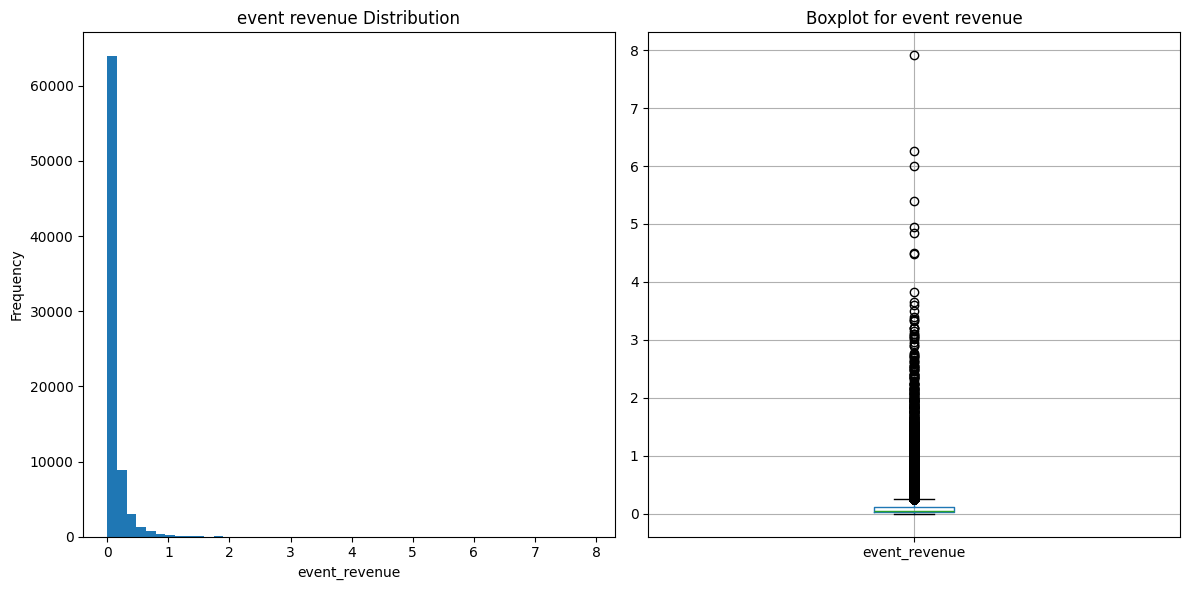

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # figsize регулирует размер графиков

# Построение гистограммы event_revenue
ad_revenue['event_revenue'].plot(kind='hist', bins=50, ax=axs[0], title='event revenue Distribution')
axs[0].set_xlabel('event_revenue')
axs[0].set_ylabel('Frequency')

# Построение Boxplot event_revenue
ad_revenue.boxplot(column='event_revenue', ax=axs[1])
axs[1].set_title('Boxplot for event revenue')

# Отображение графиков
plt.tight_layout()
plt.show()

Рассмотрим как распределено *event_revenue* на разных платформах

In [13]:
# Фильтрация данных по платформам
android_data = ad_revenue[ad_revenue['platform'] == 'android']
ios_data = ad_revenue[ad_revenue['platform'] == 'ios']

In [14]:
print("Описательная статистика для Android:")
print(android_data['event_revenue'].describe())

# Описательная статистика для iOS
print("\nОписательная статистика для iOS:")
print(ios_data['event_revenue'].describe())

Описательная статистика для Android:
count    72360.000000
mean         0.107987
std          0.191550
min          0.000000
25%          0.024210
50%          0.049446
75%          0.113870
max          7.911244
Name: event_revenue, dtype: float64

Описательная статистика для iOS:
count    6363.000000
mean        0.137504
std         0.200965
min         0.000000
25%         0.034426
50%         0.073950
75%         0.165450
max         3.603033
Name: event_revenue, dtype: float64


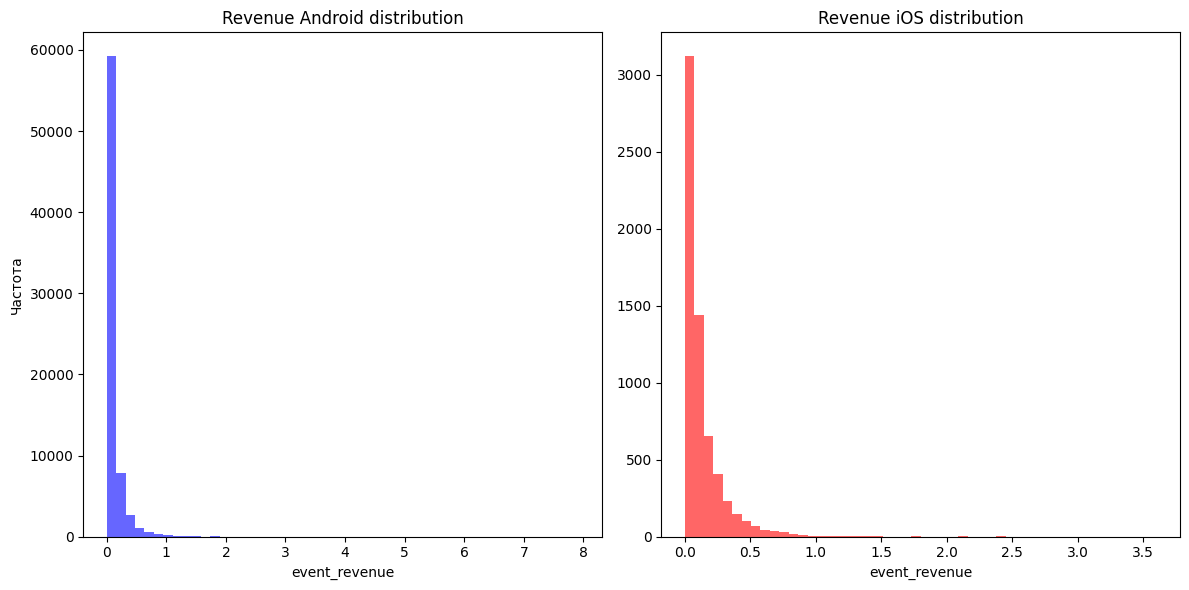

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Гистограмма для Android
axs[0].hist(android_data['event_revenue'], bins=50, alpha=0.6, color='blue')
axs[0].set_title('Revenue Android distribution')
axs[0].set_xlabel('event_revenue')
axs[0].set_ylabel('Частота')

# Гистограмма для iOS
axs[1].hist(ios_data['event_revenue'], bins=50, alpha=0.6, color='red')
axs[1].set_title('Revenue iOS distribution')
axs[1].set_xlabel('event_revenue')

# Настройка отображения
plt.tight_layout()
plt.show()

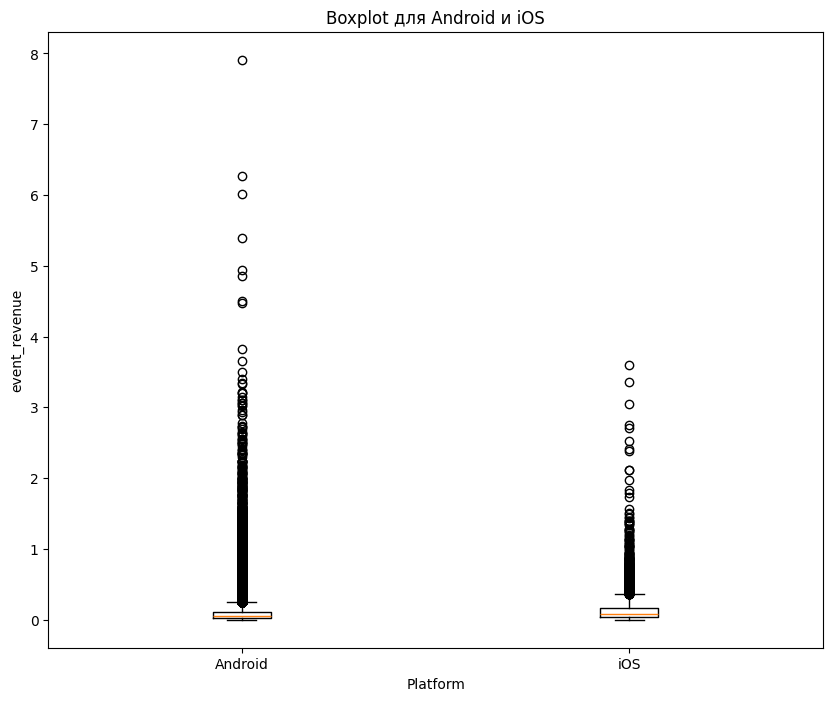

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

# Boxplot для Android и iOS
ax.boxplot([android_data['event_revenue'], ios_data['event_revenue']], labels=['Android', 'iOS'])

# Настройка графика
ax.set_title('Boxplot для Android и iOS')
ax.set_ylabel('event_revenue')
ax.set_xlabel('Platform')

# Отображение графика
plt.show()

Распределение суммы event_revenue по пользователям:

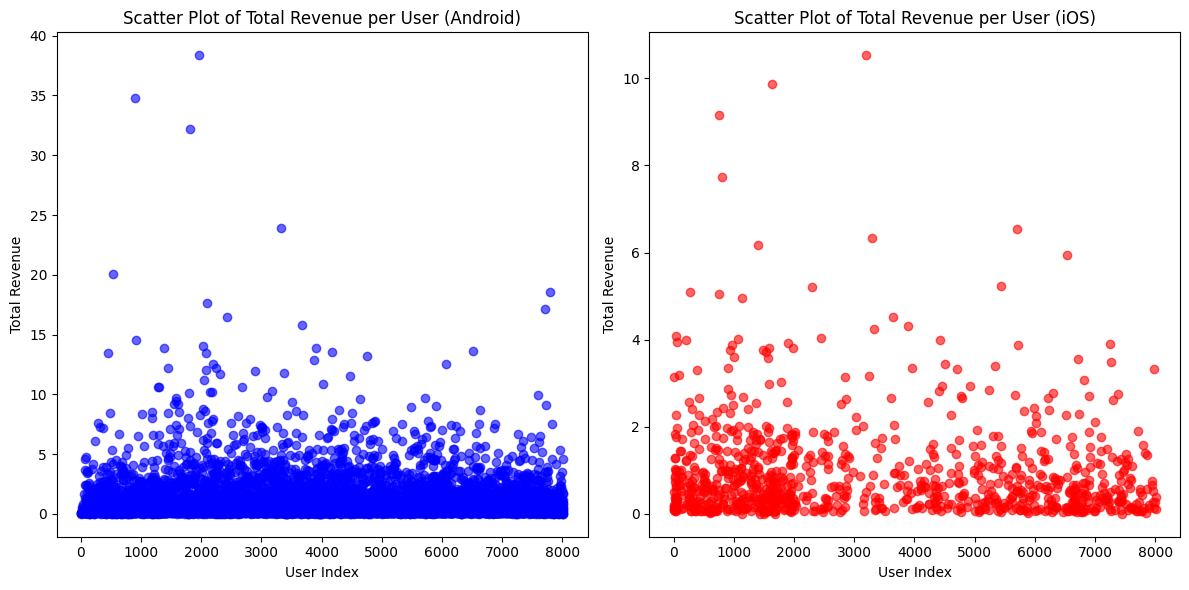

In [31]:
# Grouping data by user_id and platform, summing the total revenue for each user
grouped_data_platform = ad_revenue.groupby(['user_id', 'platform']).agg(total_revenue=('event_revenue', 'sum')).reset_index()

# Creating subplots for Android and iOS
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Android
android_data = grouped_data_platform[grouped_data_platform['platform'] == 'android']
axs[0].scatter(android_data.index, android_data['total_revenue'], color='blue', alpha=0.6)
axs[0].set_title('Scatter Plot of Total Revenue per User (Android)')
axs[0].set_xlabel('User Index')
axs[0].set_ylabel('Total Revenue')

# Plot for iOS
ios_data = grouped_data_platform[grouped_data_platform['platform'] == 'ios']
axs[1].scatter(ios_data.index, ios_data['total_revenue'], color='red', alpha=0.6)
axs[1].set_title('Scatter Plot of Total Revenue per User (iOS)')
axs[1].set_xlabel('User Index')
axs[1].set_ylabel('Total Revenue')

# Display the plots
plt.tight_layout()
plt.show()

#### **Выводы:**

#### **Статистические различия:**
- **Среднее значение выручки** на iOS выше, чем на Android, несмотря на наличие более крупных выбросов на Android. Это может означать, что пользователи iOS в целом приносят больше выручки, но без столь резких скачков, как на Android.
- **Стандартное отклонение (std)** выше на Android, что также указывает на большую изменчивость данных.

#### **Распределение event_revenue:**
- На гистограммах видно, что распределение выручки для обеих платформ имеет сильный сдвиг к нулю, с редкими случаями высоких значений.
- Выбросы более выражены для *Android*, что может говорить о том, что на этой платформе есть пользователи, которые генерируют высокие суммы выручки.
На *iOS* такие пользователи также есть, но в меньшем количестве, и их выручка не достигает таких высоких значений.

#### **event_revenue по пользователям:**
На scatter-плотах по пользователям видно, что конкретные пользователи, особенно на платформе Android, могут генерировать большое суммарное количество выручки, что подтверждает гипотезу о том, что некоторые пользователи более активны или вовлечены, что приводит к значительным выбросам в их общей выручке.
Эти пользователи могут влиять на общие метрики, такие как ARPU.

Таким образом, можно сделать вывод, что на обеих платформах существуют пользователи с высокой активностью, но на Android эти выбросы выражены сильнее. Это может указывать на необходимость таргетированной работы с этими пользователями для увеличения доходов и удержания.

#### **Построение распределения выручки (Кривая Лоренца)**:

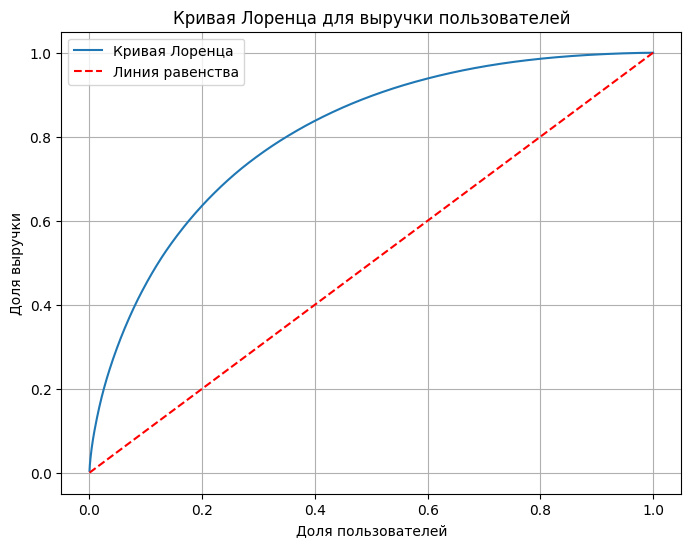

In [32]:
# Объединяем данные для анализа всех платформ (если требуется)
all_platforms_data = grouped_data_platform.copy()

# Шаг 2: Сортируем данные по общей выручке (сумме) для анализа
data_sorted = all_platforms_data.sort_values(by='total_revenue', ascending=False).reset_index(drop=True)

# Шаг 3: Добавляем кумулятивные проценты
data_sorted['cumulative_revenue'] = data_sorted['total_revenue'].cumsum()
data_sorted['cumulative_revenue_percentage'] = data_sorted['cumulative_revenue'] / data_sorted['total_revenue'].sum()
data_sorted['user_percentage'] = (data_sorted.index + 1) / len(data_sorted)

# Шаг 4: Построение кривой Лоренца
plt.figure(figsize=(8, 6))
plt.plot(data_sorted['user_percentage'], data_sorted['cumulative_revenue_percentage'], label='Кривая Лоренца')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Линия равенства')
plt.title('Кривая Лоренца для выручки пользователей')
plt.xlabel('Доля пользователей')
plt.ylabel('Доля выручки')
plt.legend()
plt.grid()
plt.show()

Сильное отклонение от линии равенства подтверждает неравномерность распределения выручки среди пользователей. Это указывает, что небольшая часть пользователей (высоко доходимые пользователи) генерирует значительную долю дохода.

####**Выявление ключевых групп пользователей**:

In [36]:
# Функция для расчета ключевых метрик
def calculate_key_metrics(data, platform_name="all"):
    if platform_name != "all":
        # Фильтруем данные для указанной платформы
        platform_data = data[data['platform'] == platform_name]
        print(f"\n=== {platform_name.upper()} ===")
    else:
        # Используем данные для всех платформ
        platform_data = data
        print("\n=== ВСЕ ПЛАТФОРМЫ ===")

    # Сортировка по общей выручке
    platform_sorted = platform_data.sort_values(by='total_revenue', ascending=False).reset_index(drop=True)

    # Добавляем кумулятивный процент выручки
    platform_sorted['cumulative_revenue'] = platform_sorted['total_revenue'].cumsum()
    platform_sorted['cumulative_revenue_percentage'] = platform_sorted['cumulative_revenue'] / platform_sorted['total_revenue'].sum()

    # Расчет доли выручки, генерируемой топ-10% пользователей
    top_10_percent = platform_sorted.iloc[:int(0.1 * len(platform_sorted))]
    revenue_top_10_percent = top_10_percent['total_revenue'].sum()
    revenue_total = platform_sorted['total_revenue'].sum()

    revenue_share_top_10 = revenue_top_10_percent / revenue_total
    print(f"Топ-10% пользователей генерируют {revenue_share_top_10:.2%} от общей выручки.")

    # Анализ пользователей, генерирующих 80% выручки (правило Парето)
    pareto_threshold = platform_sorted[platform_sorted['cumulative_revenue_percentage'] >= 0.8].index[0] + 1
    pareto_percentage = pareto_threshold / len(platform_sorted) * 100
    print(f"{pareto_percentage:.2f}% пользователей генерируют 80% выручки.")

# Расчет метрик для всех платформ
calculate_key_metrics(data_sorted, platform_name="all")

# Расчет метрик по платформам Android и iOS
calculate_key_metrics(data_sorted, platform_name="android")
calculate_key_metrics(data_sorted, platform_name="ios")


=== ВСЕ ПЛАТФОРМЫ ===
Топ-10% пользователей генерируют 44.87% от общей выручки.
34.98% пользователей генерируют 80% выручки.

=== ANDROID ===
Топ-10% пользователей генерируют 45.56% от общей выручки.
34.23% пользователей генерируют 80% выручки.

=== IOS ===
Топ-10% пользователей генерируют 37.59% от общей выручки.
41.26% пользователей генерируют 80% выручки.


**Основные выводы:**

1. Зависимость от ключевых пользователей:

- На платформе Android выручка сильнее зависит от топ-10% пользователей по сравнению с iOS.
- iOS имеет более равномерное распределение, что может указывать на более широкий сегмент платежеспособных пользователей.

2. Правило Парето:

- Для всех платформ оно частично соблюдается, однако на iOS большая доля пользователей (41.26%) генерирует 80% выручки, что показывает меньшую концентрацию доходов.

**Рекомендации:**

Для Android:

- Сфокусироваться на удержании топ-10% пользователей, так как они формируют значительную долю выручки.
- Использовать персонализированные предложения, чтобы увеличить их вовлеченность и выручку.

Для iOS:
- Рассмотреть стратегии, направленные на увеличение монетизации более широкой базы пользователей, так как доходы распределены более равномерно.
- Ориентироваться на улучшение опыта всех пользователей, чтобы повысить общую доходность.

#### **Расчёт метрик**:

Объединение данных из двух листов по полю *Install_date* и *Platform*:

In [ ]:
ad_revenue['event_date'] = pd.to_datetime(ad_revenue['event_date']).dt.date
ad_revenue['install_date'] = pd.to_datetime(ad_revenue['install_date']).dt.date
installs_data['install_date'] = pd.to_datetime(installs_data['install_date']).dt.date

In [ ]:
# Создаем таблицу cohort_data с группировкой по install_date и platform
cohort_data = installs_data.groupby(['install_date', 'platform']).agg({
    'installs': 'sum'  # Суммируем количество инсталлов
}).reset_index()
cohort_data.columns = ['install_date', 'platform', 'cohort_size']

# Вывод данных
print(cohort_data)

   install_date platform  cohort_size
0    2023-09-21  android          578
1    2023-09-21      ios          140
2    2023-09-22  android          530
3    2023-09-22      ios          141
4    2023-09-23  android          520
5    2023-09-23      ios          173
6    2023-09-24  android          764
7    2023-09-24      ios          127
8    2023-09-25  android         1258
9    2023-09-25      ios           91
10   2023-09-26  android         1465
11   2023-09-26      ios          147
12   2023-09-27  android         1451
13   2023-09-27      ios          198
14   2023-09-28  android         1380
15   2023-09-28      ios          214


Когортные группы на Android значительно больше, чем на iOS. Например, для 25 сентября на Android 1258 установок, тогда как на iOS — всего 91. Это указывает на то, что пользователи Android более многочисленны или приложение более популярно на этой платформе.

Описание расчета метрик:
1. Группировка данных:
Данные группируются по install_date, event_date и platform.

2. Для каждой группы рассчитываются:
- *DAU* (Daily Active Users): количество уникальных пользователей ('user_id': 'nunique').
- *Event Revenue*: сумма выручки за день ('event_revenue': 'sum').
- Дни с момента установки (*days_since_install*): Рассчитывается разница между event_date и install_date для каждого события, показывая, сколько дней прошло с момента установки.

3. Присоединение размера когорты (*cohort_size*):

К каждому дню и платформе добавляется размер когорты (количество пользователей, установивших приложение в install_date).

4. Далее расчитываются рассчитываются:
- *ARPU* (Average Revenue Per User): Средняя выручка на активного пользователя в день рассчитывается как:

- *Retention Rate*: Процент пользователей, которые остаются активными, рассчитывается как:
- Кумулятивная выручка (*cumulative_revenue*): Считается накопительная сумма выручки по дням для каждой когорты.
- Коэффициент роста выручки (*revenue_growth*): Накопительная выручка делится на первую дневную выручку (значение на 1-й день) для вычисления относительного роста.

5. Разделение по платформам:

Данные разделяются на две части: для Android и iOS (platform == 'android' или 'ios').

In [ ]:
# Группируем данные по когортам (дата установки) и дням активности (event_date)
daily_data = ad_revenue.groupby(['install_date', 'event_date', 'platform']).agg({
    'user_id': 'nunique',  # Считаем количество уникальных активных пользователей (DAU)
    'event_revenue': 'sum'  # Считаем выручку за день
}).reset_index()

daily_data.columns = ['install_date', 'event_date', 'platform', 'DAU', 'event_revenue']

# Рассчитываем количество дней с момента установки
daily_data['days_since_install'] = (pd.to_datetime(daily_data['event_date']) - pd.to_datetime(daily_data['install_date'])).dt.days

# Присоединяем данные по размеру когорты (cohort_size)
daily_data = daily_data.merge(cohort_data[['install_date', 'platform', 'cohort_size']], on=['install_date', 'platform'], how='left')

# ARPU (средняя выручка на активного пользователя) в день
daily_data['ARPU'] = daily_data['event_revenue'] / daily_data['DAU']

# Рассчитываем Retention Rate как процент активных пользователей (DAU) к общему количеству пользователей (размеру когорты) на день установки
daily_data['retention_rate'] = (daily_data['DAU'] / daily_data['cohort_size']) * 100

# Рассчитываем кумулятивное значение выручки для каждой когорты
daily_data['cumulative_revenue'] = daily_data.groupby(['install_date', 'platform'])['event_revenue'].cumsum()

# Выбираем первую выручку за первый день для каждой когорты
initial_revenue = daily_data.groupby(['install_date', 'platform'])['event_revenue'].transform('first')

# Рассчитываем коэффициент роста выручки выручке
daily_data['revenue_growth'] = (daily_data['cumulative_revenue'] / initial_revenue)

# Разделяем данные на платформы
daily_data_android = daily_data[daily_data['platform'] == 'android']
daily_data_ios = daily_data[daily_data['platform'] == 'ios']

#### **Анализ среднего дохода на пользователя (ARPU, Avarage Revenue Per User)**

In [ ]:
# Подсчитаем количество уникальных пользователей и выручку по платформам
platform_stats = ad_revenue.groupby('platform').agg({
    'user_id': 'nunique',  # Уникальные пользователи
    'event_revenue': 'sum'  # Суммарная выручка
}).reset_index()

# Рассчитаем общий ARPU за весь период
platform_stats['ARPU'] = platform_stats['event_revenue'] / platform_stats['user_id']

# Выведем результат
print(platform_stats)

  platform  user_id  event_revenue      ARPU
0  android     7085    7813.908686  1.102881
1      ios      933     874.936242  0.937767


In [ ]:
# Рассчитываем среднее значение ARPU по дням и кагортам
average_arpu_android = daily_data_android['ARPU'].mean()
average_arpu_ios = daily_data_ios['ARPU'].mean()

# Выводим результат
print(f"Средний ARPU для Android: {average_arpu_android:.2f}")
print(f"Средний ARPU для IOS: {average_arpu_ios:.2f}")

Средний ARPU для Android: 0.48
Средний ARPU для IOS: 0.38


 На основании предоставленных метрик ARPU можно сделать следующие выводы:

1. Средняя выручка на пользователя за весь период (ARPU):
- Android: Средний ARPU составляет 1.102881 за весь период. Это означает, что каждый пользователь Android в среднем приносит чуть больше одной единицы выручки на протяжении всего времени использования приложения.
- iOS: Средний ARPU составляет 0.937767. Хотя это значение ниже, чем у Android, оно довольно близко к единице, что указывает на стабильную, но меньшую выручку на пользователя по сравнению с Android.
2. Средняя выручка на пользователя в день по когортам:
- Android: Средний дневной ARPU составляет 0.48. Это может свидетельствовать о более активных пользователях на платформе Android, которые приносят значительную часть выручки за короткий период времени.
- iOS: Средний дневной ARPU составляет 0.38, что несколько ниже, чем на Android. Это подтверждает гипотезу о том, что пользователи iOS приносят меньше выручки в день, но при этом более стабильно в течение всего периода использования приложения.

Разница между общим ARPU и средним ARPU по дням может объясняться как наличием пользователей с высокой выручкой, так и тем, что некоторые пользователи совершают регулярные действия в приложении на протяжении длительного времени, что приводит к накоплению выручки. Выбросы и долгосрочная активность являются ключевыми факторами, которые увеличивают общий ARPU по сравнению с дневным.

#### **Анализ активности пользователей (DAU, Daily Active Users)**

Следующий график представляет анализ активности пользователей (DAU, Daily Active Users) на платформах Android и iOS.
Он показывает, сколько пользователей, установивших приложение в разные дни (когорты), были активны в каждый день после установки.

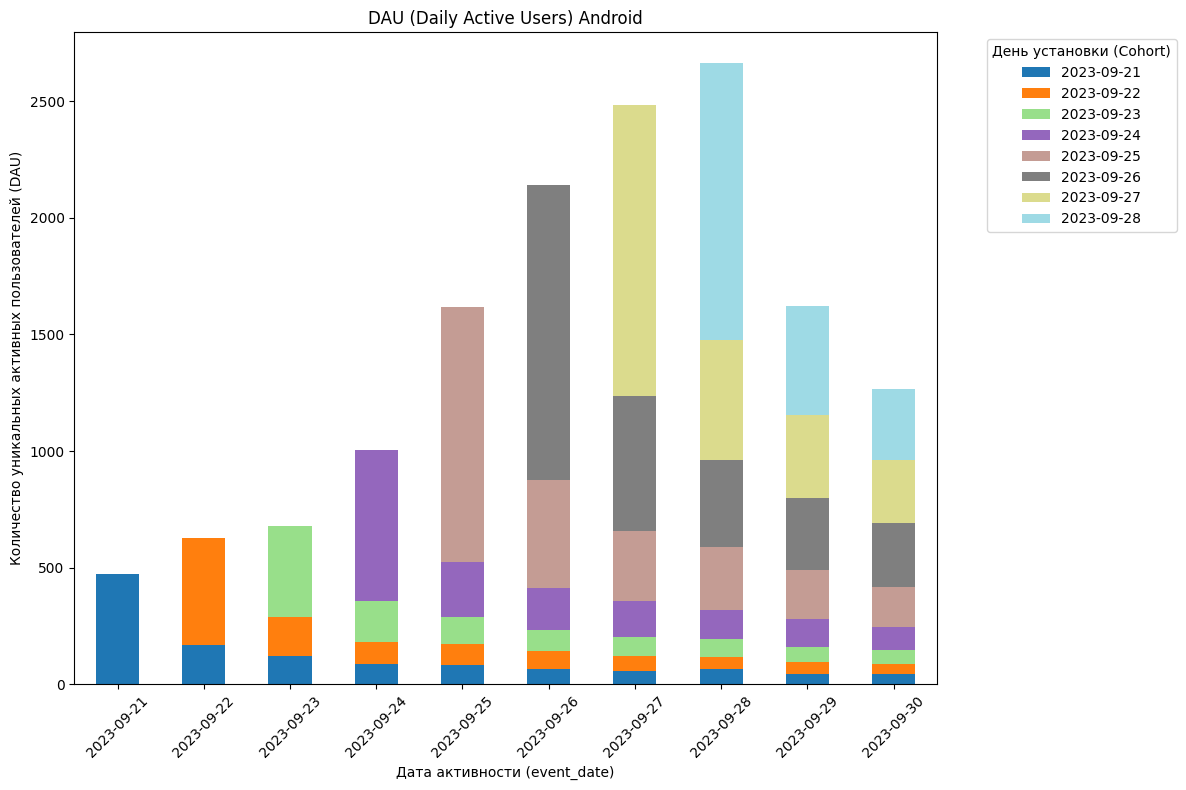

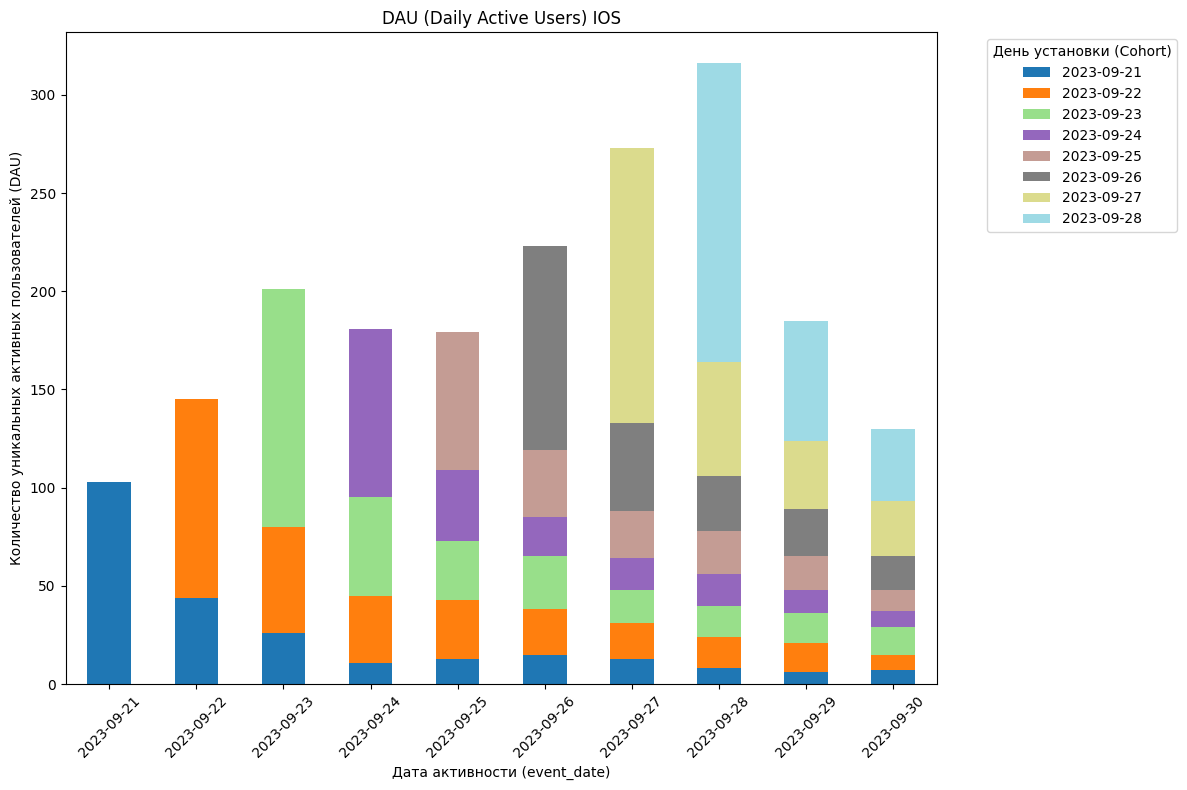

In [ ]:
# Строим сводную таблицу активных пользователей для stacked bar chart по дням
pivot_dau = daily_data_android.pivot_table(values='DAU', index='event_date', columns='install_date', aggfunc='sum', fill_value=0)

# android
pivot_dau.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab20')
plt.title('DAU (Daily Active Users) Android')
plt.xlabel('Дата активности (event_date)')
plt.ylabel('Количество уникальных активных пользователей (DAU)')
plt.xticks(rotation=45)
plt.legend(title='День установки (Cohort)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ios
pivot_dau = daily_data_ios.pivot_table(values='DAU', index='event_date', columns='install_date', aggfunc='sum', fill_value=0)

pivot_dau.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab20')
plt.title('DAU (Daily Active Users) IOS')
plt.xlabel('Дата активности (event_date)')
plt.ylabel('Количество уникальных активных пользователей (DAU)')
plt.xticks(rotation=45)
plt.legend(title='День установки (Cohort)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Android показывает более высокую активность пользователей, с пиковыми значениями DAU, достигающими более 2500 уникальных активных пользователей в день.

iOS имеет более низкие показатели активности, с максимумом около 300 пользователей в день.

В целом, можно предположить, что на Android пользователи более активно возвращаются в приложение после установки, что может говорить о лучшей вовлеченности или более эффективной рекламе на этой платформе.

#### **Удержание пользователей (Retention)**
Эти таблицы и графики показывают процент удержания пользователей (Retention) для каждой когорты (дата установки) на Android и iOS,
начиная с 0-го дня после установки и до 9-го дня.

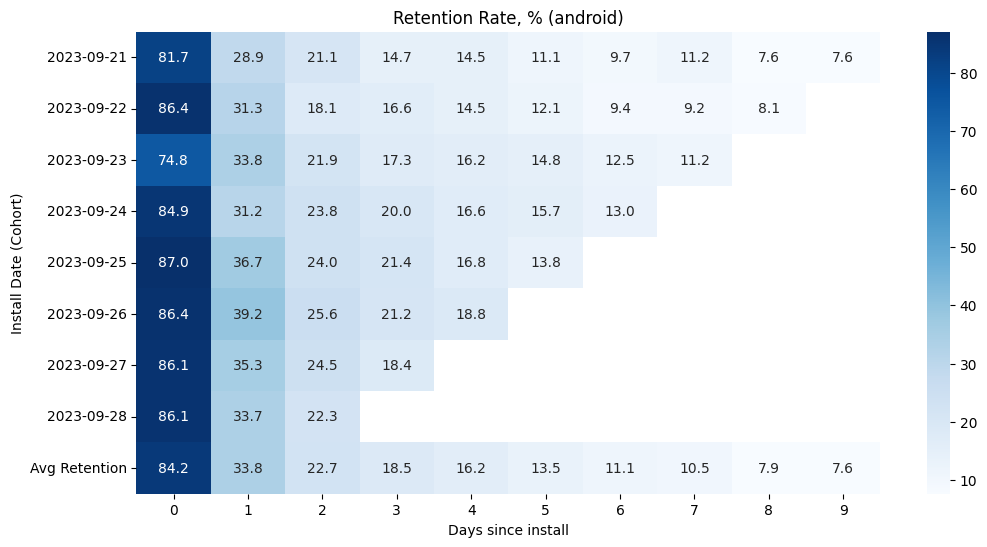

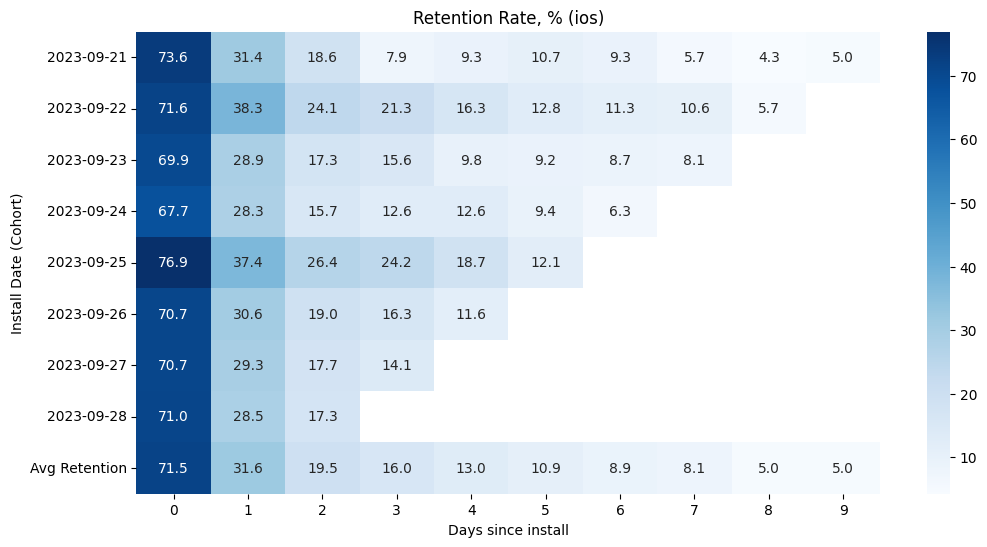

In [ ]:
# Рассчитываем среднее значение retention по каждому дню (days_since_install)
mean_retention_android = daily_data_android.groupby('days_since_install')['retention_rate'].mean()
retention_pivot_android = daily_data_android.pivot(index='install_date', columns='days_since_install', values='retention_rate')
retention_pivot_android.loc['Avg Retention'] = mean_retention_android

# Визуализация Retention Rate
plt.figure(figsize=(12, 6))
sns.heatmap(retention_pivot_android, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title('Retention Rate, % (android)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

# Аналогичный код для iOS
mean_retention_ios = daily_data_ios.groupby('days_since_install')['retention_rate'].mean()
retention_pivot_ios = daily_data_ios.pivot(index='install_date', columns='days_since_install', values='retention_rate')
retention_pivot_ios.loc['Avg Retention'] = mean_retention_ios

plt.figure(figsize=(12, 6))
sns.heatmap(retention_pivot_ios, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title('Retention Rate, % (ios)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

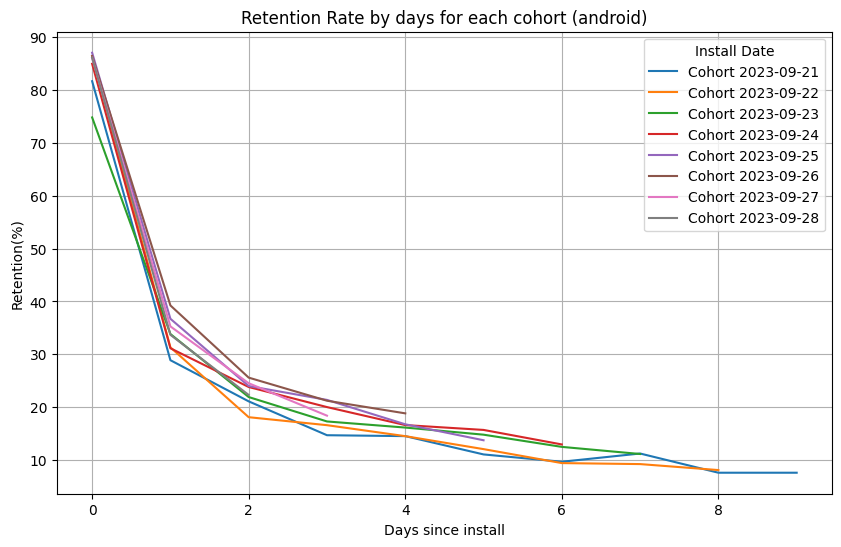

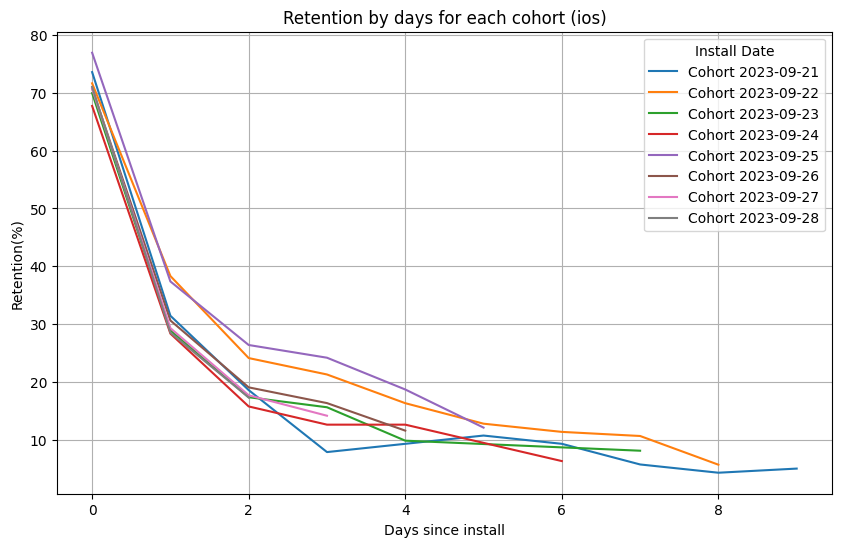

In [ ]:
# Строим график Retention для каждой когорты
plt.figure(figsize=(10, 6))

for cohort in daily_data_android['install_date'].unique():
    cohort_data = daily_data_android[daily_data_android['install_date'] == cohort]
    plt.plot(cohort_data['days_since_install'], cohort_data['retention_rate'], label=f'Cohort {pd.to_datetime(cohort).strftime("%Y-%m-%d")}')

plt.title('Retention Rate by days for each cohort (android)')
plt.xlabel('Days since install')
plt.ylabel('Retention(%)')
plt.legend(title='Install Date')
plt.grid(True)
plt.show()

# Строим график Retention для каждой когорты
plt.figure(figsize=(10, 6))

for cohort in daily_data_ios['install_date'].unique():
    cohort_data = daily_data_ios[daily_data_ios['install_date'] == cohort]
    plt.plot(cohort_data['days_since_install'], cohort_data['retention_rate'], label=f'Cohort {pd.to_datetime(cohort).strftime("%Y-%m-%d")}')

plt.title('Retention by days for each cohort (ios)')
plt.xlabel('Days since install')
plt.ylabel('Retention(%)')
plt.legend(title='Install Date')
plt.grid(True)
plt.show()

#### **Прогноз удержания пользователей на 30 день**

На основании представленных данных и графиков я выбрала модель «forgetting curve» (https://app2top.ru/marketing/modeliruem-uderzhanie-pol-zovatelej-v-poiskah-optimal-noj-formuly-99392.html) для описания поведения пользователей, поскольку она наиболее точно отражает характер изменений уровня удержания по когортам на протяжении времени.

1. Резкое снижение удержания в первые дни: Как видно на графиках для платформ Android и iOS, в первые дни после установки приложения уровень удержания пользователей значительно падает. Это согласуется с моделью кривой забывания, которая описывает быструю потерю интереса или информации сразу после первого взаимодействия, если не предприняты специальные меры для их сохранения.

2. Замедление снижения удержания: После первых нескольких дней падение удержания замедляется, что также характерно для кривой забывания. Модель предполагает, что после быстрого начального спада активность или интерес пользователей стабилизируются на более низком уровне, что подтверждается данными.

3. Схожие паттерны среди когорт: Независимо от даты установки, все когорты демонстрируют один и тот же паттерн: резкий спад активности в начале и стабилизация через несколько дней. Это свидетельствует о том, что пользователи проходят через одинаковый процесс потери интереса к приложению, что позволяет обоснованно применить модель забывания.


Исходя из этих факторов, модель «forgetting curve» наиболее адекватно объясняет наблюдаемые тренды в данных и помогает лучше понять поведение пользователей на протяжении первых дней после установки приложения.

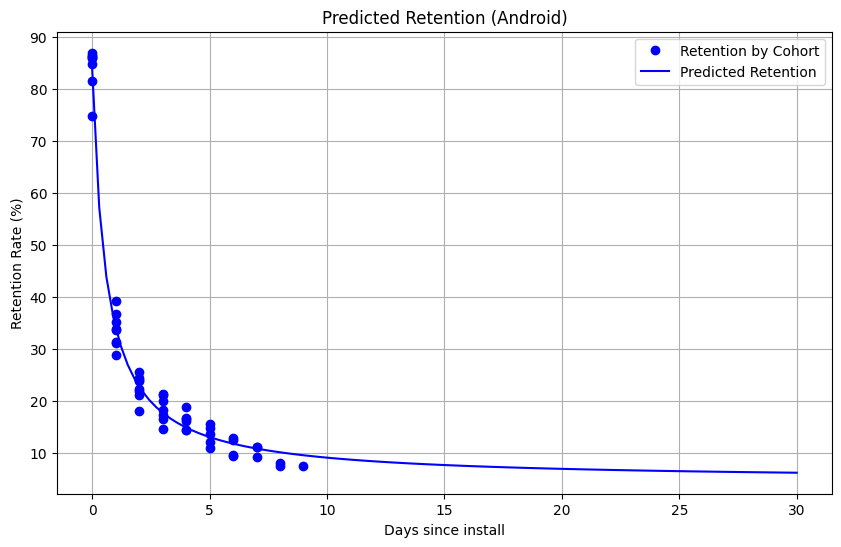

Predicted Retention on Day 30 for Android: 6.24%
RMSE for Android: 2.59
R^2 for Android: 0.99


In [ ]:
# Используем гиперболическую модель для кривой забывания
def forgetting_curve(x, a, b, c):
    return a / (b + x) + c

# Объединяем все точки данных для каждой когорты
days_android = daily_data_android['days_since_install'].values
retention_android = daily_data_android['retention_rate'].values

# Обучаем модель на всех точках
popt_android, _ = curve_fit(forgetting_curve, days_android, retention_android)

# Предсказания по дням
days_pred = np.linspace(0, 30, 100)  # Диапазон для предсказаний на будущее
retention_pred_android = forgetting_curve(days_pred, *popt_android)  # Предсказания на основе модели

# Предсказания для обучающих данных
retention_pred_train_android = forgetting_curve(days_android, *popt_android)

# Оценка модели для Android
rmse_android = np.sqrt(mean_squared_error(retention_android, retention_pred_train_android))
r2_android = r2_score(retention_android, retention_pred_train_android)

# Расчёт коэффициента удержания на 30-й день
retention_30_day_android = forgetting_curve(30, *popt_android)

# Визуализация
plt.figure(figsize=(10, 6))

# Android
plt.plot(days_android, retention_android, 'o', label='Retention by Cohort', color='blue')
plt.plot(days_pred, retention_pred_android, '-', label='Predicted Retention', color='blue')

# Оформление
plt.xlabel('Days since install')
plt.ylabel('Retention Rate (%)')
plt.title('Predicted Retention (Android)')
plt.legend()
plt.grid(True)
plt.show()

# Вывод коэффициента удержания на 30-й день
print(f'Predicted Retention on Day 30 for Android: {retention_30_day_android:.2f}%')

# Вывод метрик RMSE и R^2
print(f'RMSE for Android: {rmse_android:.2f}')
print(f'R^2 for Android: {r2_android:.2f}')

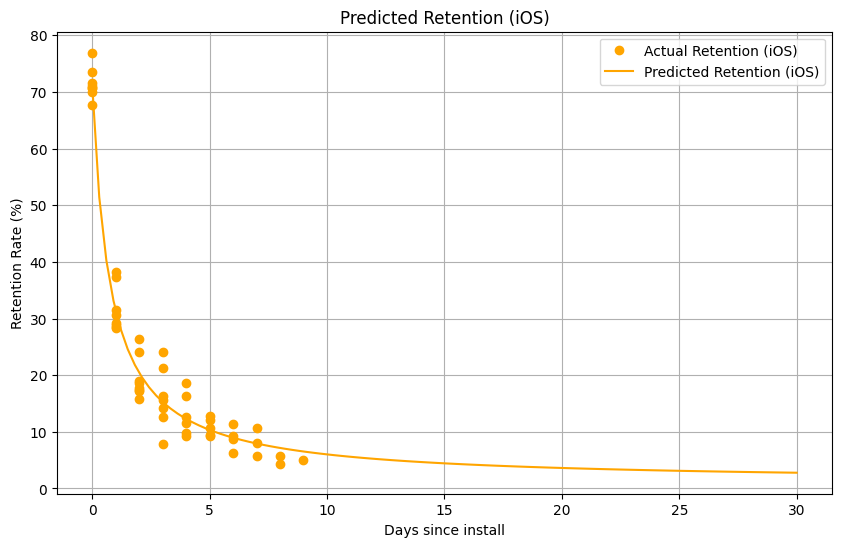

Predicted Retention on Day 30 for iOS: 2.78%
RMSE for iOS: 3.31
R^2 for iOS: 0.98


In [ ]:
# Данные для iOS
days_all_ios = daily_data_ios['days_since_install'].values
retention_all_ios = daily_data_ios['retention_rate'].values

# Зададим настроенные начальные параметры p0
initial_params = [73, 2, 5]

# Обучаем модель на всех точках с увеличенным числом итераций
popt_ios_all, _ = curve_fit(forgetting_curve, days_all_ios, retention_all_ios, p0=initial_params)

# Предсказания по дням
days_pred = np.linspace(0, 30, 100)  # Диапазон для предсказаний на будущее
retention_pred_ios_all = forgetting_curve(days_pred, *popt_ios_all)  # Предсказания на основе модели

# Предсказания для обучающих данных
retention_pred_train_ios = forgetting_curve(days_all_ios, *popt_ios_all)

# Оценка модели для iOS
rmse_ios = np.sqrt(mean_squared_error(retention_all_ios, retention_pred_train_ios))
r2_ios = r2_score(retention_all_ios, retention_pred_train_ios)

# Расчёт коэффициента удержания на 30-й день
retention_30_day_ios = forgetting_curve(30, *popt_ios_all)

# Визуализация
plt.figure(figsize=(10, 6))

# iOS
plt.plot(days_all_ios, retention_all_ios, 'o', label='Actual Retention (iOS)', color='orange')
plt.plot(days_pred, retention_pred_ios_all, '-', label='Predicted Retention (iOS)', color='orange')

# Оформление
plt.xlabel('Days since install')
plt.ylabel('Retention Rate (%)')
plt.title('Predicted Retention (iOS)')
plt.legend()
plt.grid(True)
plt.show()

# Вывод коэффициента удержания на 30-й день
print(f'Predicted Retention on Day 30 for iOS: {retention_30_day_ios:.2f}%')

# Вывод метрик RMSE и R^2
print(f'RMSE for iOS: {rmse_ios:.2f}')
print(f'R^2 for iOS: {r2_ios:.2f}')


Модели для Android и iOS показали высокую точность с
𝑅^2 0.99 и 0.98 соответственно, что свидетельствует о хорошем объяснении данных. Среднеквадратичная ошибка (RMSE) составила 2.59 для Android и 3.31 для iOS, что указывает на небольшое отклонение предсказанных значений от фактических.


Предсказанное удержание на 30-й день составляет 6.24% для Android и 2.78% для iOS, что говорит о более активных пользователях на платформе Android, но обе модели демонстрируют стабильные результаты.

#### **Доход по когортам (Revenue)**

Это таблицы показывают ежедневный доход (Revenue), получаемый от каждой когорты пользователей за каждый день после установки.
Каждая строка в таблице соответствует дате установки (кохорта), а каждый столбец — это день с момента установки (Days since install).

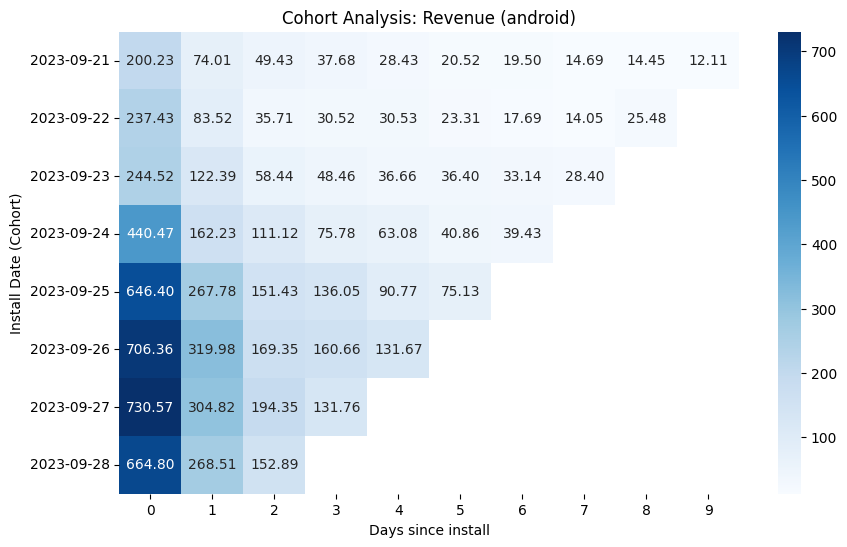

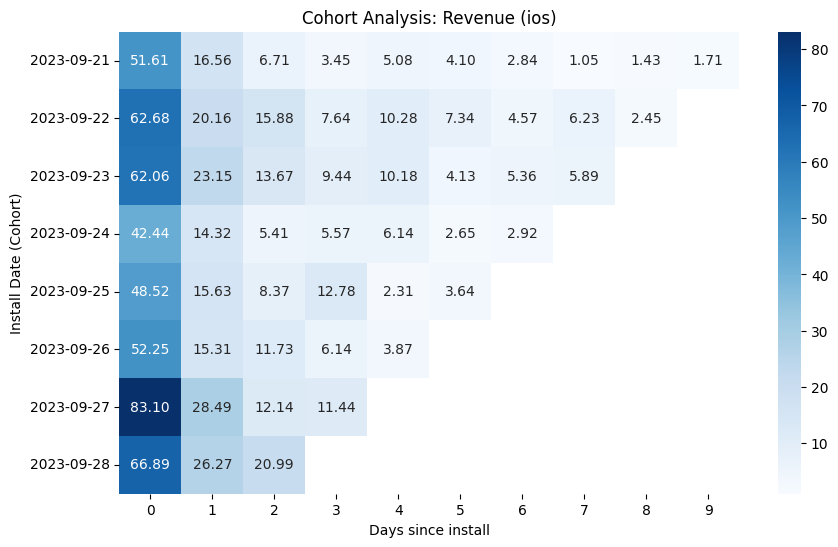

In [ ]:
revenue_table = daily_data_android.pivot(index='install_date', columns='days_since_install', values='event_revenue')

# Создаем таблицу с подсветкой с помощью heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(revenue_table, annot=True, cmap="Blues", fmt=".2f")
plt.title('Cohort Analysis: Revenue (android)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

revenue_table = daily_data_ios.pivot(index='install_date', columns='days_since_install', values='event_revenue')

# Создаем таблицу с подсветкой с помощью heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(revenue_table, annot=True, cmap="Blues", fmt=".2f")
plt.title('Cohort Analysis: Revenue (ios)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

#### **Кумулятивный доход по кагортам (Cumulative Revenue)**


Эти таблицы показывают накопленный (кумулятивный) доход от каждой когорты за каждый день после установки.

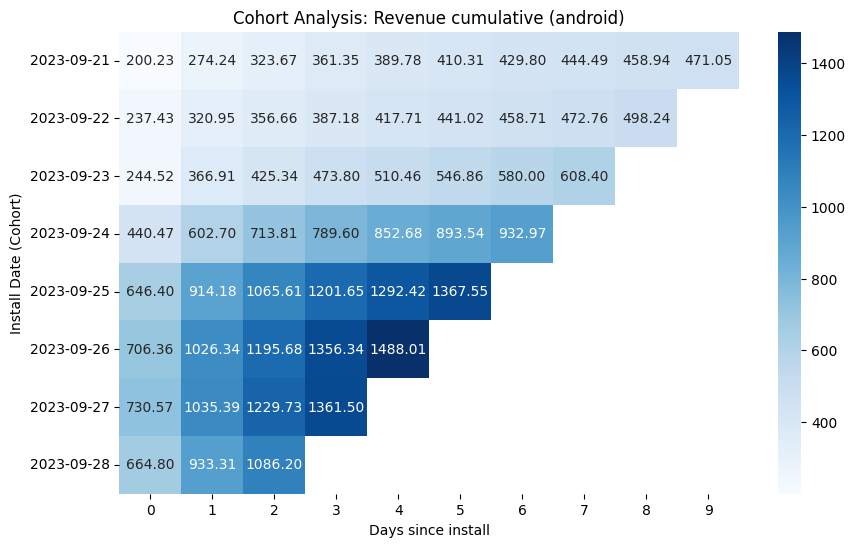

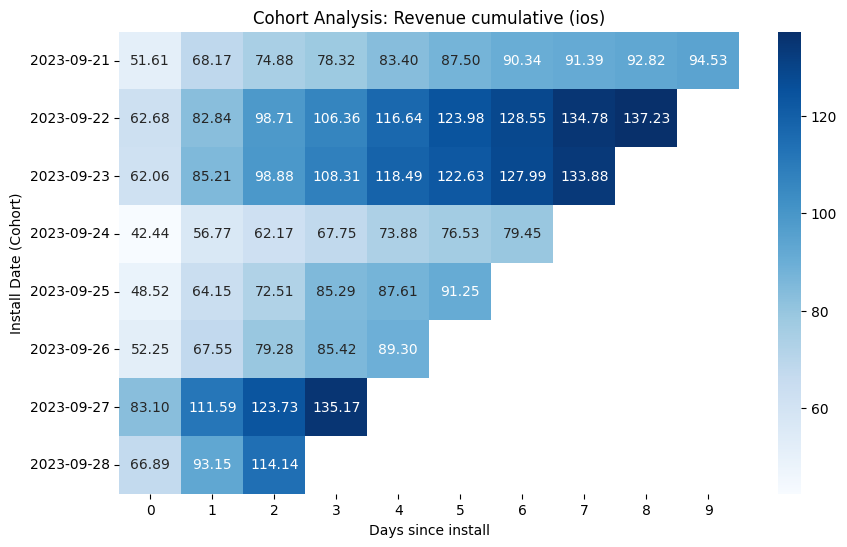

In [ ]:
revenue_table = daily_data_android.pivot(index='install_date', columns='days_since_install', values='cumulative_revenue')

# Создаем таблицу с подсветкой с помощью heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(revenue_table, annot=True, cmap="Blues", fmt=".2f")
plt.title('Cohort Analysis: Revenue cumulative (android)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

revenue_table = daily_data_ios.pivot(index='install_date', columns='days_since_install', values='cumulative_revenue')

# Создаем таблицу с подсветкой с помощью heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(revenue_table, annot=True, cmap="Blues", fmt=".2f")
plt.title('Cohort Analysis: Revenue cumulative (ios)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

#### **Рост кумулятивного дохода (Revenue growth rate)**

Эти таблицы представляют собой рост кумулятивного дохода по дням для каждой когорты пользователей, установивших приложение в разные дни. Значение на 0-й день — это 1.00, что означает 100% от первоначального дохода. Все последующие значения показывают, как увеличился кумулятивный доход относительно первого дня. Таблицы кумулятивного удержания дохода дают важную информацию о том, как нарастает доход (revenue) от пользователей с момента их установки приложения.

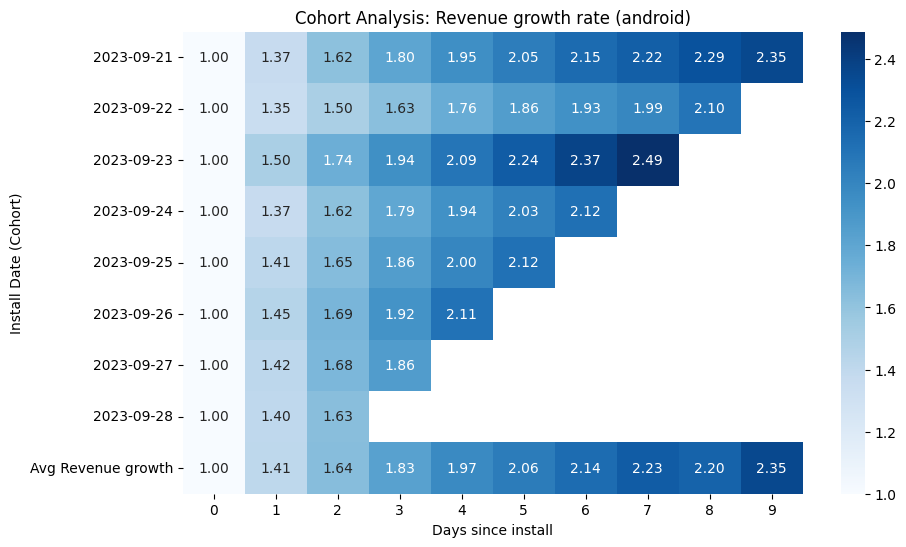

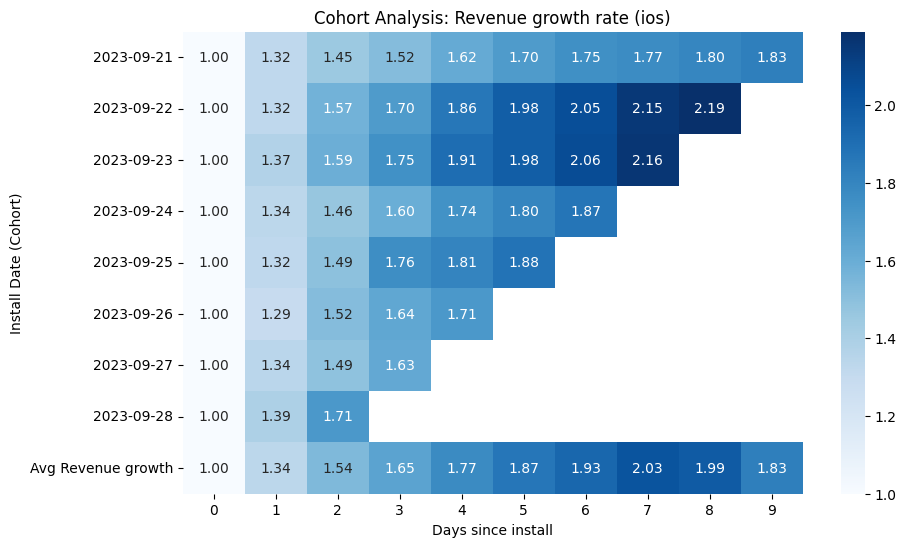

In [ ]:
# Рассчитываем среднее значение revenue growth rate для каждого дня (days_since_install) для Android
mean_revenue_growth_android = daily_data_android.groupby('days_since_install')['revenue_growth'].mean()
revenue_table_android = daily_data_android.pivot(index='install_date', columns='days_since_install', values='revenue_growth')
revenue_table_android.loc['Avg Revenue growth'] = mean_revenue_growth_android

# Визуализация тепловой карты с добавлением строки среднего значения
plt.figure(figsize=(10, 6))
sns.heatmap(revenue_table_android, annot=True, cmap="Blues", fmt=".2f")
plt.title('Cohort Analysis: Revenue growth rate (android)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

# Аналогичный расчет для iOS
mean_revenue_growth_ios = daily_data_ios.groupby('days_since_install')['revenue_growth'].mean()
revenue_table_ios = daily_data_ios.pivot(index='install_date', columns='days_since_install', values='revenue_growth')
revenue_table_ios.loc['Avg Revenue growth'] = mean_revenue_growth_ios

plt.figure(figsize=(10, 6))
sns.heatmap(revenue_table_ios, annot=True, cmap="Blues", fmt=".2f")
plt.title('Cohort Analysis: Revenue growth rate (ios)')
plt.xlabel('Days since install')
plt.ylabel('Install Date (Cohort)')
plt.show()

#### **Прогноз роста выручки на 30-й день**
Построения модели роста кумулятивного дохода (Revenue growth rate) для Android и iOS,
с использованием всех точек данных и предсказание удержания дохода на 30-й день.

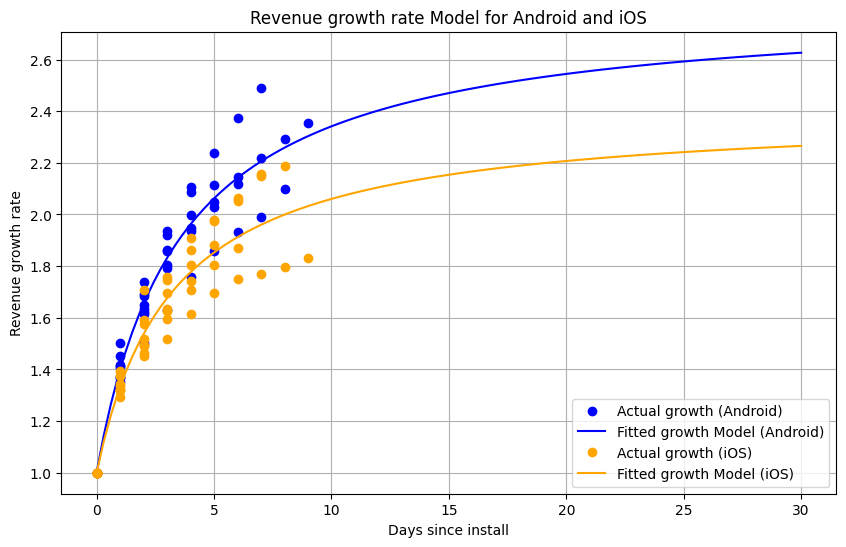

Predicted Revenue growth on Day 30 for Android: 2.63
Predicted Revenue growth on Day 30 for iOS: 2.27
RMSE for Android: 0.10
R^2 for Android: 0.94
RMSE for iOS: 0.10
R^2 for iOS: 0.91


In [ ]:
# Данные для Android
days_android = daily_data_android['days_since_install'].values
revenue_growth_android = daily_data_android['revenue_growth'].values

# Данные для iOS
days_ios = daily_data_ios['days_since_install'].values
revenue_growth_ios = daily_data_ios['revenue_growth'].values

# Подгонка моделей на всех точках данных
popt_android, _ = curve_fit(forgetting_curve, days_android, revenue_growth_android)
popt_ios, _ = curve_fit(forgetting_curve, days_ios, revenue_growth_ios)

# Предсказания по дням для визуализации
days_pred = np.linspace(0, 30, 100)
growth_pred_android = forgetting_curve(days_pred, *popt_android)
growth_pred_ios = forgetting_curve(days_pred, *popt_ios)

# Предсказания для обучающих данных (для расчёта метрик)
growth_pred_train_android = forgetting_curve(days_android, *popt_android)
growth_pred_train_ios = forgetting_curve(days_ios, *popt_ios)

# Оценка модели для Android
rmse_android = np.sqrt(mean_squared_error(revenue_growth_android, growth_pred_train_android))
r2_android = r2_score(revenue_growth_android, growth_pred_train_android)

# Оценка модели для iOS
rmse_ios = np.sqrt(mean_squared_error(revenue_growth_ios, growth_pred_train_ios))
r2_ios = r2_score(revenue_growth_ios, growth_pred_train_ios)

# Визуализация
plt.figure(figsize=(10, 6))

# Android
plt.plot(days_android, revenue_growth_android, 'o', label='Actual growth (Android)', color='blue')
plt.plot(days_pred, growth_pred_android, '-', label='Fitted growth Model (Android)', color='blue')

# iOS
plt.plot(days_ios, revenue_growth_ios, 'o', label='Actual growth (iOS)', color='orange')
plt.plot(days_pred, growth_pred_ios, '-', label='Fitted growth Model (iOS)', color='orange')

# Оформление
plt.xlabel('Days since install')
plt.ylabel('Revenue growth rate')
plt.title('Revenue growth rate Model for Android and iOS')
plt.legend()
plt.grid(True)
plt.show()

# Предсказание удержания на 30-й день
predicted_revenue_growth_d30_android =  forgetting_curve(30, *popt_android)
predicted_revenue_growth_d30_ios = forgetting_curve(30, *popt_ios)

# Вывод метрик и предсказаний
print(f'Predicted Revenue growth on Day 30 for Android: {predicted_revenue_growth_d30_android:.2f}')
print(f'Predicted Revenue growth on Day 30 for iOS: {predicted_revenue_growth_d30_ios:.2f}')

# Вывод метрик RMSE и R^2
print(f'RMSE for Android: {rmse_android:.2f}')
print(f'R^2 for Android: {r2_android:.2f}')
print(f'RMSE for iOS: {rmse_ios:.2f}')
print(f'R^2 for iOS: {r2_ios:.2f}')

На основании оценки модели:


RMSE для Android (0.10) и iOS (0.10): Очень низкие значения RMSE говорят о том,
что модель хорошо предсказывает фактические данные с минимальными отклонениями.


R² для Android (0.94) и iOS (0.91): Высокие значения R² указывают на то, что модель объясняет практически всю вариацию данных, особенно для Android.
Модель для Android предсказывает 30-дневное удержание выручки на уровне 2.63, а для iOS — 2.27.
Линии хорошо следуют за фактическими данными, особенно для Android, где кривая более точно соответствует точкам на графике.

Увеличение ревеню нулевого дня (день установки игры), первого и третьего дня к 30-му дню:

In [ ]:
# Фактические средние значения revenue growth для Android на 0, 1, 3 дни
revenue_growth_d0_android = mean_revenue_growth_android.loc[0]
revenue_growth_d1_android= mean_revenue_growth_android.loc[1]
revenue_growth_d3_android = mean_revenue_growth_android.loc[3]

# Фактические средние значения revenue growth для iOS на 0, 1, 3 дни
revenue_growth_d0_ios = mean_revenue_growth_ios.loc[0]
revenue_growth_d1_ios= mean_revenue_growth_ios.loc[1]
revenue_growth_d3_ios = mean_revenue_growth_ios.loc[3]


# Создадим таблицу
data = {
    "Day": [0, 1, 3],
    "Android Actual growth": [revenue_growth_d0_android, revenue_growth_d1_android, revenue_growth_d3_android],
    "iOS Actual growth": [revenue_growth_d0_ios, revenue_growth_d1_ios, revenue_growth_d3_ios]
}

data['Android Increase to D30'] = predicted_revenue_growth_d30_android / data['Android Actual growth']
data['iOS Increase to D30'] = predicted_revenue_growth_d30_ios / data['iOS Actual growth']

df_summary = pd.DataFrame(data)
print(df_summary)

   Day  Android Actual growth  iOS Actual growth  Android Increase to D30  \
0    0               1.000000           1.000000                 2.626260   
1    1               1.409826           1.337936                 1.862826   
2    3               1.829785           1.653627                 1.435283   

   iOS Increase to D30  
0             2.265479  
1             1.693264  
2             1.370006  
